In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-11-09 11:18:32--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   176MB/s    in 0.4s    

2024-11-09 11:18:33 (176 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Creating generators for train, validation, and test sets
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

# Load images directly from the test directory
test_images = []
test_image_names = sorted(os.listdir(test_dir))  # Sort to maintain consistent order

# Define valid image extensions
valid_extensions = {".jpg", ".jpeg", ".png"}

for img_name in test_image_names:
    # Check if the file is an image based on its extension
    if os.path.splitext(img_name)[1].lower() in valid_extensions:
        img_path = os.path.join(test_dir, img_name)
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img) / 255.0  # Normalize here directly
        test_images.append(img_array)

# Print the number of loaded images
print(f"Found {len(test_images)} images belonging to 1 class.")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 class.


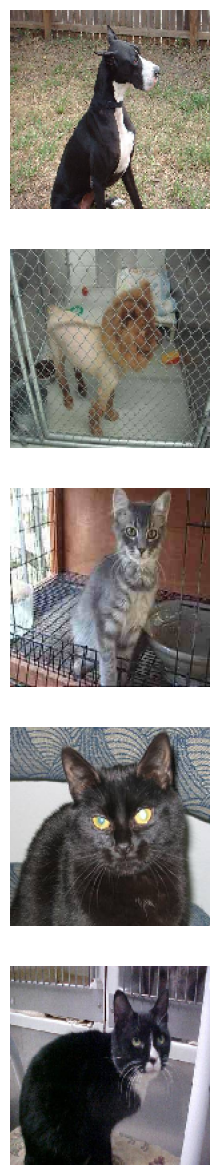

In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=40,        # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,    # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,   # Randomly shift images vertically by up to 20%
    shear_range=0.2,          # Apply shear transformations
    zoom_range=0.2,           # Randomly zoom in on images
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill in newly created pixels after a transformation
)

Found 2000 images belonging to 2 classes.


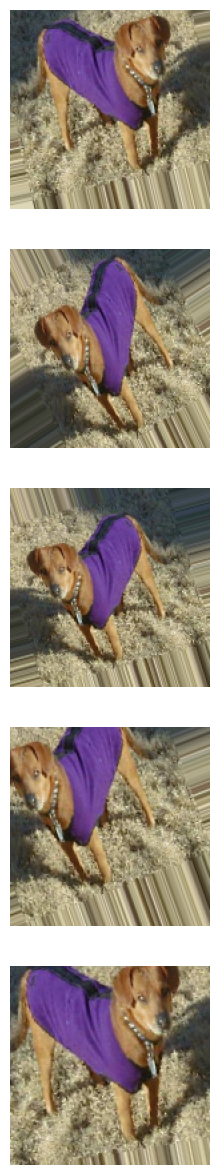

In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:
# 7
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='tanh', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Fourth convolutional block
    Conv2D(128, (3, 3), activation='tanh'),
    MaxPooling2D(2, 2),

    # Flatten and fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

# Set a smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


# Print model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Adjust steps_per_epoch and validation_steps by rounding up
steps_per_epoch = total_train // batch_size
print(f"Steps per epoch: {steps_per_epoch}")
validation_steps = (total_val+1) // batch_size
print(f"Validation steps: {validation_steps}")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    x=train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)


Steps per epoch: 15
Validation steps: 7
Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 0.5715 - loss: 0.6807 - val_accuracy: 0.6172 - val_loss: 0.6680
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.6172 - loss: 0.6612 - val_accuracy: 0.5385 - val_loss: 0.6826
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.6086 - loss: 0.6634 - val_accuracy: 0.6161 - val_loss: 0.6567
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6406 - loss: 0.6538 - val_accuracy: 0.5288 - val_loss: 0.6879
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 0.5838 - loss: 0.6630 - val_accuracy: 0.6049 - val_loss: 0.6506
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.6094 - loss: 0.6646 - val_accuracy: 0.6346 - val_loss: 0.6299
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.6213 - loss: 0.6471 - val_accuracy: 0.6473 - val_loss: 0.6449
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7031

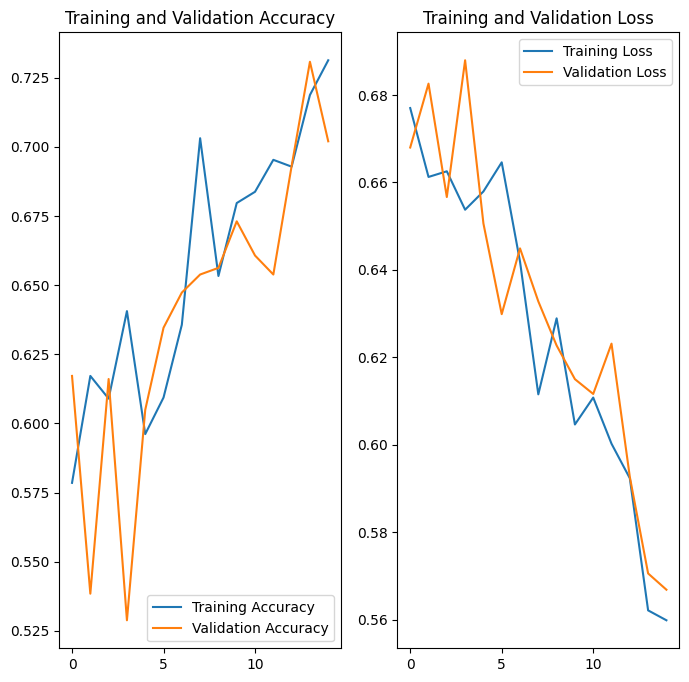

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


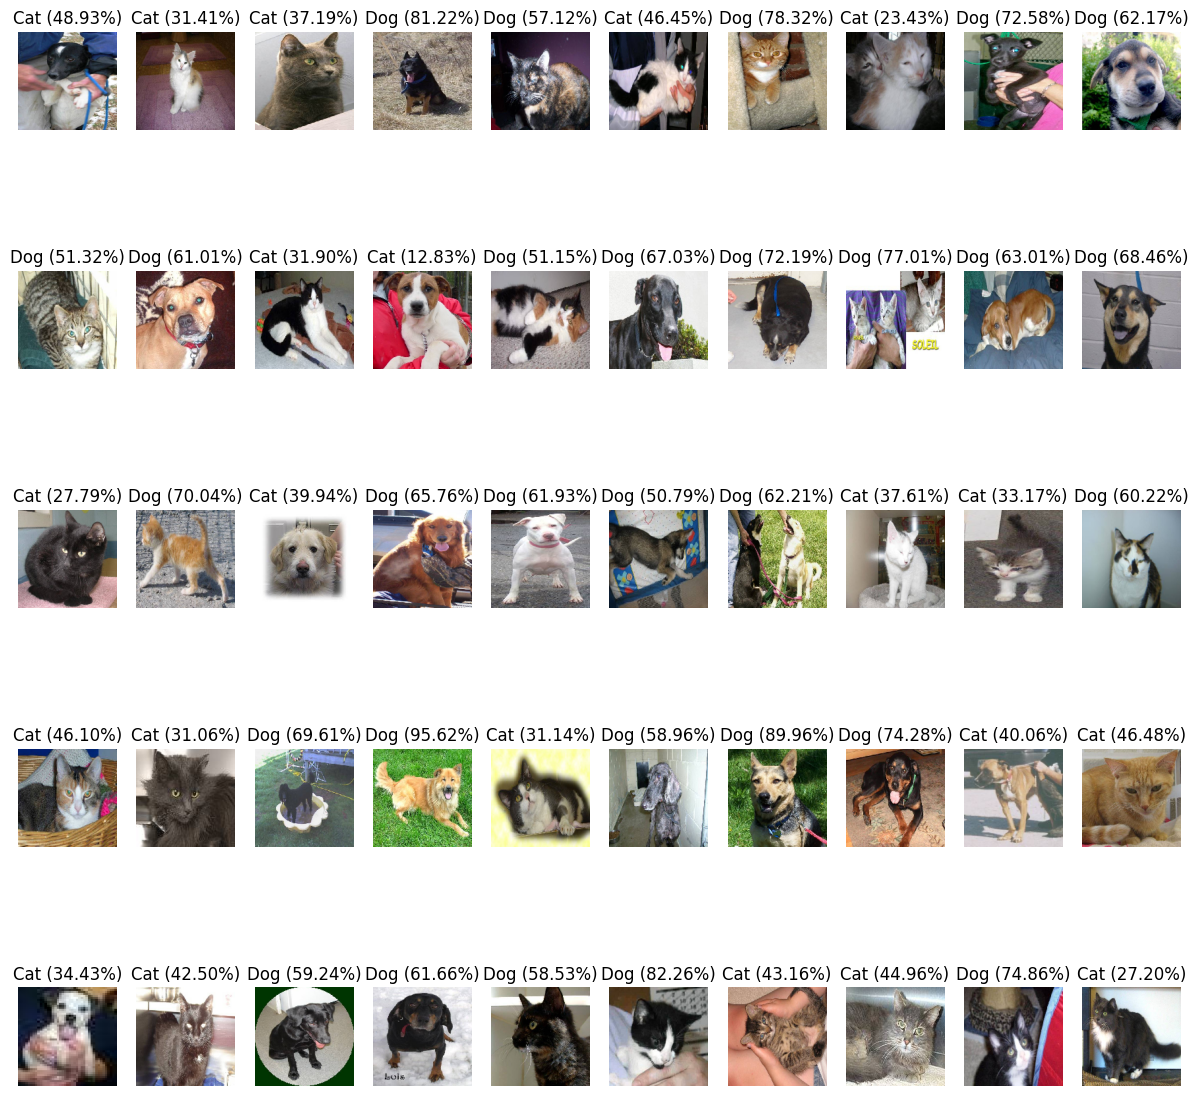

In [ ]:
# 10
test_images = np.array(test_images)
predictions = model.predict(test_images)
# Convert probabilities to integer labels (0 for cat, 1 for dog)
probabilities = [int(round(p[0])) for p in predictions]

# Helper function to plot images with predictions
def plotImages(images, probabilities):
    plt.figure(figsize=(15, 15))
    for i in range(len(images)):
        plt.subplot(5, 10, i+1)
        plt.imshow(images[i])
        plt.title(f"{'Dog' if probabilities[i] == 1 else 'Cat'} ({predictions[i][0]*100:.2f}%)")
        plt.axis('off')
    plt.show()


# Plot the test images with predicted probabilities
plotImages(test_images, probabilities[:len(test_images)])


In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
